# Amazon Rekognition demonstration

[Amazon Rekognition](https://aws.amazon.com/pt/rekognition/) is a managed service for image recognition. It has several features like: object classification, face detection, image moderation, face recognition, etc. It's main features will be presented in this Notebook.

For more information about the Python API (boto3) used in this demonstration, click:

http://boto3.readthedocs.io/en/latest/reference/services/rekognition.html#Rekognition.Client.detect_labels

In [3]:
# checking the boto3 version
import boto3
if boto3.__version__ < "1.4.8":
    !conda update --yes boto3
    print("Please, reload your kernel now.")

In [4]:
%matplotlib inline

# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as disp

from PIL import Image, ImageDraw
from IPython.display import Markdown

from notebook import notebookapp

In [5]:
## Here we will create the Rekognition client. 
client = boto3.client('rekognition')

dataset_dir="https://workshopml.spock.cloud/reko_data.tar.gz"
base_dir="/tmp/reko"

In [6]:
!mkdir -p $base_dir
!curl -s $dataset_dir | tar -xz -C $base_dir
!ln -sf $base_dir/star_wars.mp4 .

## Helper functions

In [7]:
# Reads an image from the disk and coverts it to a bytearray
def load_image(filename):
    with open(filename, "rb") as imageFile:
      f = imageFile.read()
      return bytearray(f)

In [8]:
# Converts an array to a Pandas dataframe
def convert_to_dataframe(labels):
    data = { 'Label': [], 'Confidence': [] }

    for label in labels:
        data['Label'].append( label['Name'] )
        data['Confidence'].append( label['Confidence'] )

    return pd.DataFrame( data )[ ['Label', 'Confidence'] ]

In [11]:
# Invokes Rekognition to extract labels (metadata) from an image
def get_labels(filename):
    response = client.detect_labels(
        Image={'Bytes': load_image(filename)},
        MaxLabels=5,
        MinConfidence=50
    )
    return convert_to_dataframe(response['Labels'])

In [12]:
# Invokes Rekognition to extract moderation labels from an image
def get_moderation_labels(filename):
    response = client.detect_moderation_labels(
        Image={ 'Bytes': load_image(filename) },
        MinConfidence=50
    )
    return convert_to_dataframe(response['ModerationLabels'])

In [13]:
# Converts a bounding box to a rectangle
def create_bounding_box(bbox, size):
    if len(bbox) != 4:
        return None
    return [ 
        bbox['Left'] * size[0], bbox['Top'] * size[1],
        (bbox['Left'] * size[0]) + bbox['Width'] * size[0], 
        (bbox['Top'] * size[1]) + bbox['Height'] * size[1]
    ]

In [14]:
# Invokes Rekognition for recognizing celebrities in an image
def recognize_celebrity(filename):
    response = client.recognize_celebrities(
        Image={'Bytes': load_image(filename)}
    )
    img = Image.open(filename)
    if len(response['CelebrityFaces']) == 0:
        return (None, None, None)
    
    bbox = create_bounding_box( response['CelebrityFaces'][0]['Face']['BoundingBox'], img.size )
    confidence = response['CelebrityFaces'][0]['Face']['Confidence']
    name = response['CelebrityFaces'][0]['Name']
    
    return (name, confidence, bbox )

In [15]:
# Draws a bound box in an image
def draw_bounding_box(filename, bbox):
    img = Image.open(filename)

    draw = ImageDraw.Draw(img)
    draw.line([(bbox[0], bbox[1]), (bbox[2], bbox[1])], fill='yellow', width=4)
    draw.line([(bbox[2], bbox[1]), (bbox[2], bbox[3])], fill='yellow', width=4)
    draw.line([(bbox[2], bbox[3]), (bbox[0], bbox[3])], fill='yellow', width=4)
    draw.line([(bbox[0], bbox[1]), (bbox[0], bbox[3])], fill='yellow', width=4)
    del draw
    plt.imshow(img)

In [16]:
# Detects a face and it's characteristics in a given image
def detect_face(filename):
    response = client.detect_faces(
        Image={'Bytes': load_image(filename)},
        Attributes=['ALL']
    )
    if len(response['FaceDetails']) == 0:
        return None
    img = Image.open(filename)
    metadata = response['FaceDetails'][0]
    confidence = metadata['Confidence']
    bbox = create_bounding_box( metadata['BoundingBox'], img.size )
    labels = []
    for label in ('Smile', 'Eyeglasses', 'Sunglasses', 'Gender', 'Beard', 'Mustache', 'EyesOpen', 'MouthOpen'):
        labels.append( {'Name': label + "({})".format( metadata[label]['Value']), 'Confidence': metadata[label]['Confidence'] } )
    for emo in metadata['Emotions']:
        labels.append( {'Name': emo['Type'], 'Confidence': emo['Confidence'] } )
    return ( confidence, bbox, convert_to_dataframe(labels) )

In [17]:
# Compares similarities between two faces
def compare_faces(filenameA, filenameB):
    response = client.compare_faces(
        SourceImage={'Bytes': load_image( filenameA )},
        TargetImage={'Bytes': load_image( filenameB )}
    )
    if len(response['FaceMatches']) == 0:
        return ( None, None, None)
    imgA = Image.open(filenameA)
    imgB = Image.open(filenameB)
    
    similarity = response['FaceMatches'][0]['Similarity']
    bboxA = create_bounding_box( response['SourceImageFace']['BoundingBox'], imgA.size )
    bboxB = create_bounding_box( response['FaceMatches'][0]['Face']['BoundingBox'], imgB.size )
    return (similarity, bboxA, bboxB )

In [18]:
def delete_collection(name):
    try:
        response = client.delete_collection(
            CollectionId=name
        )
    except Exception as e:
        print("Collection not found")

## Detects scenes and objects - client.detect_labels()

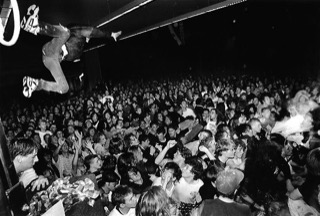

In [19]:
disp.Image(base_dir + '/mosh_thumb.jpg')

In [21]:
get_labels(base_dir + '/mosh.jpg' )

,Label,Confidence
0,Human,99.152443
1,People,99.152435
2,Person,99.152443
3,Audience,98.967537
4,Crowd,98.967537


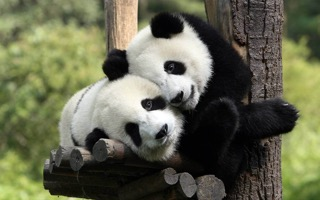

In [22]:
disp.Image(base_dir + '/pandas_thumb.jpg' )

In [23]:
get_labels( base_dir + '/pandas.jpg' )

,Label,Confidence
0,Animal,99.082001
1,Bear,99.082001
2,Giant Panda,99.082001
3,Mammal,99.082001
4,Wildlife,99.082001


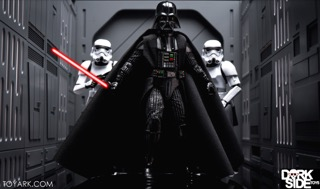

In [24]:
disp.Image(base_dir + '/darth_thumb.jpg' )

In [25]:
get_labels( base_dir + '/darth.jpg' )

,Label,Confidence
0,Face,58.755272
1,Human,58.755272
2,Person,58.755272
3,Portrait,58.755272
4,Accessories,51.373661


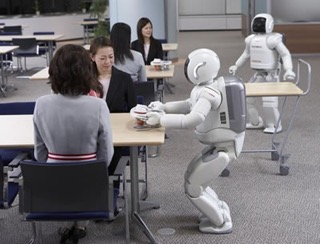

In [26]:
disp.Image(base_dir + '/robots2_thumb.jpg' )

In [27]:
get_labels( base_dir + '/robots2.jpg' )

,Label,Confidence
0,Robot,99.322304
1,Human,98.925728
2,People,98.925705
3,Person,98.925728
4,Appliance,79.396072


## Detects sugestive content + moderation - client.detect_moderation_labels()

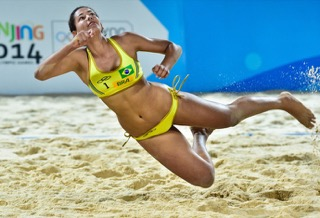

In [29]:
disp.Image(base_dir + '/voley_thumb.jpg' )

In [30]:
get_moderation_labels( base_dir + '/voley.jpg' )

,Label,Confidence
0,Suggestive,72.404625
1,Female Swimwear Or Underwear,72.404625


### Now let's combine moderation with object classification

In [31]:
labels = pd.concat([ get_moderation_labels( base_dir + '/voley.jpg' ), get_labels( base_dir + '/voley.jpg' ) ], ignore_index=True)
labels.sort_values(['Confidence'], ascending=False)

,Label,Confidence
2,Bikini,98.720551
3,Clothing,98.720551
4,Swimwear,98.720551
5,Human,98.344734
6,People,98.344681
0,Suggestive,72.404625
1,Female Swimwear Or Underwear,72.404625


## Recognizing celebrities - client.recognize_celebrities()

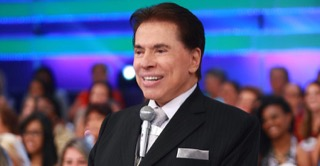

In [32]:
disp.Image(base_dir + '/silvio_thumb.jpg' )

Silvio Santos 99.9999771118164


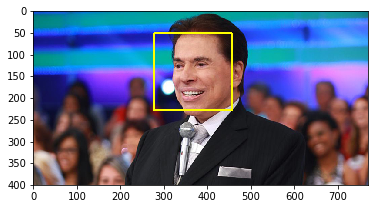

In [33]:
(name, confidence, bbox) = recognize_celebrity( base_dir + '/silvio.jpg' )
print( name, confidence )
draw_bounding_box(base_dir + '/silvio.jpg', bbox )

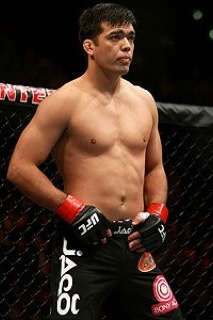

In [34]:
disp.Image(base_dir + '/machida_thumb.jpg' )

Lyoto Machida 99.99999237060547


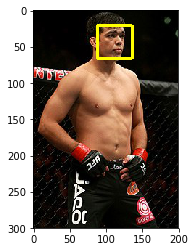

In [35]:
(name, confidence, bbox) = recognize_celebrity( base_dir + '/machida.jpg' )
print( name, confidence )
if bbox: draw_bounding_box(base_dir + '/machida.jpg', bbox )

## Face detection - client.detect_face()

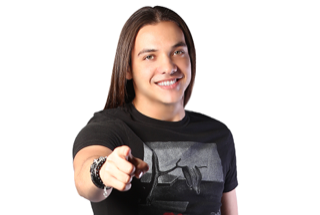

In [36]:
disp.Image(base_dir + '/wesley_thumb.png' )

Confidence that a face was found: 99.99584197998047


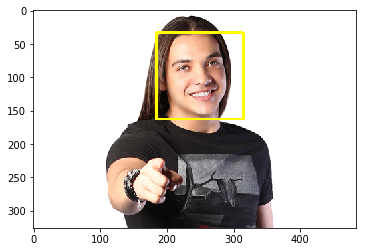

In [39]:
(confidence, bbox, labels) = detect_face( base_dir + '/wesley.png')
print( 'Confidence that a face was found: {}'.format( confidence ) )
if bbox: draw_bounding_box( base_dir + '/wesley.png', bbox )

In [40]:
labels

,Label,Confidence
0,Smile(True),99.504021
1,Eyeglasses(False),99.999802
2,Sunglasses(False),99.763199
3,Gender(Male),89.843735
4,Beard(False),99.687309
5,Mustache(False),99.090439
6,EyesOpen(True),99.985939
7,MouthOpen(False),92.005615
8,HAPPY,99.917648
9,CALM,0.530672


## Comparing two faces - client.compare_faces()

### Source face

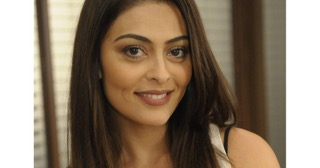

In [41]:
disp.Image(base_dir + '/ju_paes_thumb.jpg' )

### Target faces

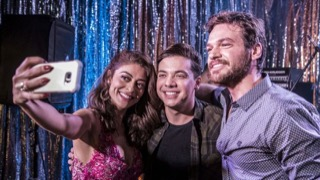

In [43]:
disp.Image(base_dir + '/ju_we_em_thumb.jpg' )

In [44]:
(similarity, bboxA, bboxB) = compare_faces(base_dir + '/ju_paes.jpg', base_dir + '/ju_we_em.jpg')
print( 'Similarity: {}'.format( similarity ) )

Similarity: 90.0


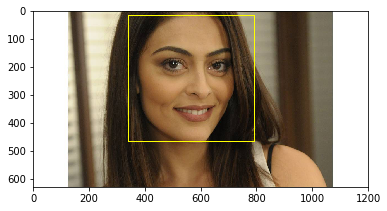

In [45]:
if bboxA: draw_bounding_box(base_dir + '/ju_paes.jpg', bboxA )

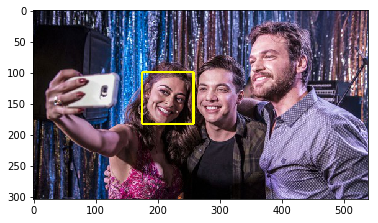

In [46]:
if bboxB: draw_bounding_box(base_dir + '/ju_we_em.jpg', bboxB )

## Searching faces in a collection - client.search_faces()
### Collection ID: Funcionarios
Now let's suppose you have a company and you control who enters and leave the company's building by using face recognition. You keep a collection of authorized faces and check agains that collection if a given person is allowed or not to enter/leave.

In [53]:
try:
    delete_collection("Funcionarios")
    response = client.create_collection(
        CollectionId='Funcionarios'
    )
    faces = {
        'Glenn': base_dir + '/coll_glenn.png',
        'Rick': base_dir + '/coll_rick.jpg',
        'Michonne': base_dir + '/coll_michonne.jpg',
        'Negan': base_dir + '/coll_negan.jpg',
        'Turma': base_dir + '/coll_turma.jpg'
    }
    for ext_id, image_name in faces.items():
        response = client.index_faces(
            CollectionId='Funcionarios',
            Image={ 'Bytes': load_image( image_name ) },
            ExternalImageId=ext_id,
        )
        if len(response['FaceRecords']) > 0:
            for i in response['FaceRecords']:
                print( ext_id, i['Face']['FaceId'])
except Exception as e:
    print(e)

Glenn 05de1a5e-ca3e-43a9-bfde-005859093698
Rick 89bf6190-3a03-464f-9893-9ea38e318370
Michonne d1daea3a-b52b-4517-a430-915751919b33
Negan 95ae345b-5baf-45be-ad80-29f865511002
Turma 864bd6f2-6df3-48e3-9ff6-77ba6dbb96b5
Turma 3f8000b4-0ed6-4d13-8004-47c0e426f10d
Turma 78daf6ea-9539-473b-b4b2-22ce59e3675b
Turma 3776b7b5-bd4c-4813-b46c-074e6e90d1c2
Turma 86f1aa23-dd3f-4366-9596-10ebb2843f3e
Turma 71d93d21-c6be-4efb-b95e-fe99c3c19b07
Turma 6108beeb-03d7-4c92-aeff-77751d5dd2eb
Turma cae006cc-0540-40b6-8360-6ad003981bc6


### Ok. Now that our collection is ready, let's see it's content

In [58]:
faces = {}
bboxes = {}
counter = 1
for face in client.list_faces( CollectionId='Funcionarios', MaxResults=20 )['Faces']:
    if faces.get( face['ExternalImageId'] ) == None: 
        faces[ face['ExternalImageId'] ] = []
    faces[ face['ExternalImageId'] ].append( face['FaceId'] )
    bboxes[ face['ExternalImageId'] ] = face['BoundingBox']
    counter += 1

FaceId: 05de1a5e-ca3e-43a9-bfde-005859093698


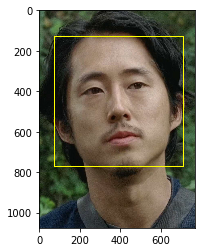

In [59]:
print( "FaceId: {}".format( faces['Glenn'][0] ) )
img = Image.open( base_dir + '/coll_glenn.png' )
draw_bounding_box(base_dir + '/coll_glenn.png', create_bounding_box( bboxes['Glenn'], img.size ) )

FaceId: 89bf6190-3a03-464f-9893-9ea38e318370


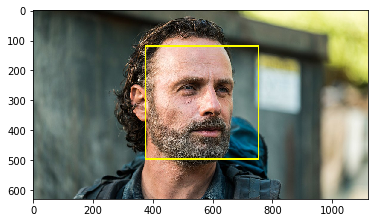

In [60]:
print( "FaceId: {}".format( faces['Rick'][0] ) )
img = Image.open( base_dir + '/coll_rick.jpg' )
draw_bounding_box(base_dir + '/coll_rick.jpg', create_bounding_box( bboxes['Rick'], img.size ) )

FaceId: d1daea3a-b52b-4517-a430-915751919b33


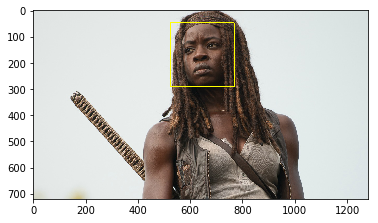

In [61]:
print( "FaceId: {}".format( faces['Michonne'][0] ) )
img = Image.open( base_dir + '/coll_michonne.jpg' )
draw_bounding_box(base_dir + '/coll_michonne.jpg', create_bounding_box( bboxes['Michonne'], img.size ) )

FaceId: 95ae345b-5baf-45be-ad80-29f865511002


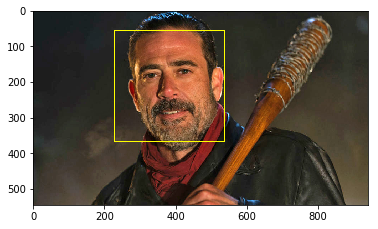

In [62]:
print( "FaceId: {}".format( faces['Negan'][0] ) )
img = Image.open( base_dir + '/coll_negan.jpg' )
draw_bounding_box(base_dir + '/coll_negan.jpg', create_bounding_box( bboxes['Negan'], img.size ) )

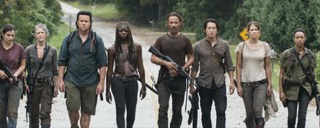

In [63]:
disp.Image(base_dir + '/coll_turma_thumb.jpg' )

In [64]:
face_counter = 1
for faceid in faces['Turma']:
    print( "FaceId{}: {}".format( face_counter, faceid ) )
    face_counter += 1

FaceId1: 3776b7b5-bd4c-4813-b46c-074e6e90d1c2
FaceId2: 3f8000b4-0ed6-4d13-8004-47c0e426f10d
FaceId3: 6108beeb-03d7-4c92-aeff-77751d5dd2eb
FaceId4: 71d93d21-c6be-4efb-b95e-fe99c3c19b07
FaceId5: 78daf6ea-9539-473b-b4b2-22ce59e3675b
FaceId6: 864bd6f2-6df3-48e3-9ff6-77ba6dbb96b5
FaceId7: 86f1aa23-dd3f-4366-9596-10ebb2843f3e
FaceId8: cae006cc-0540-40b6-8360-6ad003981bc6


### Now, let's search for Michonne in the collection - client.search_faces()

Similarity: 98.13800048828125


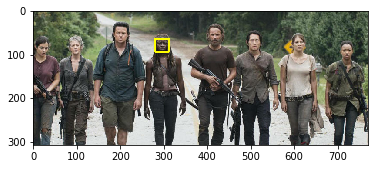

In [65]:
id_michonne = faces['Michonne'][0]
metadata = client.search_faces(
    CollectionId='Funcionarios',
    FaceId=id_michonne,
    MaxFaces=20
)['FaceMatches'][0]
print( 'Similarity: {}'.format( metadata['Similarity'] ) )
img = Image.open( base_dir + '/coll_turma.jpg' )
draw_bounding_box(base_dir + '/coll_turma.jpg', create_bounding_box( metadata['Face']['BoundingBox'], img.size ) )

### Then, let's try to find Glenn by using another picture - client.search_faces_by_image()

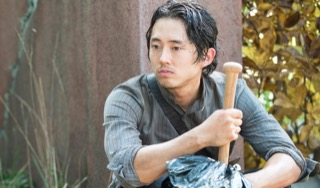

In [66]:
disp.Image(base_dir + '/coll_glenn2_thumb.jpg' )

In [68]:
faces = client.search_faces_by_image(
    CollectionId='Funcionarios',
    Image={ 'Bytes': load_image( base_dir + '/coll_glenn2.jpg') },
    MaxFaces=20
)['FaceMatches']
print( '# Mached faces in the collection: {}'.format( len(faces)))

# Mached faces in the collection: 2


### We found Glenn in which pictures?

Similarity: 98.3449478149414


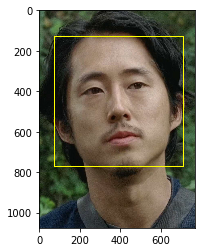

In [71]:
print( 'Similarity: {}'.format( faces[0]['Similarity'] ) )
img = Image.open( base_dir + '/coll_glenn.png' )
draw_bounding_box(base_dir + '/coll_glenn.png', create_bounding_box( faces[0]['Face']['BoundingBox'], img.size ) )

Similarity: 96.38633728027344


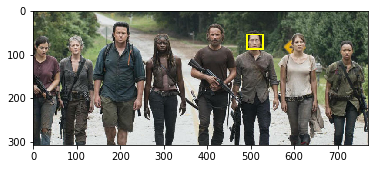

In [72]:
print( 'Similarity: {}'.format( faces[1]['Similarity'] ) )
img = Image.open( base_dir + '/coll_turma.jpg' )
draw_bounding_box(base_dir + '/coll_turma.jpg', create_bounding_box( faces[1]['Face']['BoundingBox'], img.size ) )

### Alright. Now let's see what happens if we use an unknown face (for the collection) for searching

In [74]:
faces = client.search_faces_by_image(
    CollectionId='Funcionarios',
    Image={ 'Bytes': load_image( base_dir + '/ju_paes.jpg') },
    MaxFaces=20
)['FaceMatches']
print( '# Mached faces in the collection: {}'.format( len(faces)))

# Mached faces in the collection: 0


# Text in Image client.detect_text()

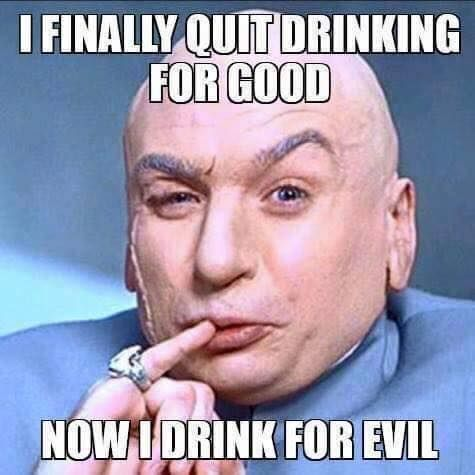

In [75]:
disp.Image(base_dir + '/dr_evil.jpg' )

In [76]:
response = client.detect_text(
    Image={ 'Bytes': load_image( base_dir + '/dr_evil.jpg') },
)
for i in response['TextDetections']:
    print( 'Text[%s] Confidence[%f]' % (i['DetectedText'], i['Confidence']) )

Text[I FINALLY QUIT] Confidence[94.956757]
Text[DRINKING] Confidence[99.946480]
Text[FOR] Confidence[99.115921]
Text[GOOD] Confidence[99.991264]
Text[NOW I DRINK FOR EVIL] Confidence[97.833817]
Text[I] Confidence[86.820518]
Text[FINALLY] Confidence[99.981880]
Text[QUIT] Confidence[98.067863]
Text[DRINKING] Confidence[99.946480]
Text[FOR] Confidence[99.115921]
Text[GOOD] Confidence[99.991264]
Text[NOW] Confidence[99.883698]
Text[I] Confidence[91.468903]
Text[DRINK] Confidence[99.978729]
Text[FOR] Confidence[99.367714]
Text[EVIL] Confidence[98.470024]


# Video Analysis

Now, right click and 'Save link as' on the following link:
<a href="star_wars.mp4">Star Wars</a><br>
Go to the Rekognition console and upload it to see the new Video Analysis functionality.

# The end :)

In [79]:
disp.Image(base_dir + '/the_end_thumb.jpg' )

# Clean up

In [77]:
delete_collection("Funcionarios")

In [78]:
!rm -rf $base_dir